## Multimodal Retrieval Augmented Generation (RAG) with Voyage AI

##### Note: This example requires a KDB.AI endpoint and API key. Sign up for a free [KDB.AI account](https://kdb.ai/get-started).

This example explores preparing, embedding, and storing both text and image data within a KDB.AI vector database. Our goal is to store both images and text within the same vector space so we can search over both modalities at the same time. KDB.AI can then be used as a retrieval tool within a RAG pipeline for both text and images, making it a multimodal retriever.

The dataset we are working with contains images of several different animals, and text descriptions of those animals. After implementation, a user should be able to write a query (or use an image) regarding any of these animals and get returned both images and text related to the animal of interest.

While this is a simple use-case, we hope it highlights how you can implement a similar flow with your real-world use-cases.

The method in this notebook uses a multimodal embedding model from Voyage AI called "voyage-multimodal-3" to embed both text and images within the same vector space.

### Agenda:
0. Setup
1. Helper Functions
2. Prepare Data
3. Embed Texts and Images
4. Set Up KDB.AI Vector Database table
5. Insert data into KDB.AI Vector Database
6. Query Vector Database to Retrieve Most Relevant Data
7. Retrieval Augmented Generation
8. Drop the table

Voyage AI: https://www.voyageai.com/

Animal Images Source: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

## 0. Setup
 Install requirements and import necessary packages

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.

In [ ]:
!pip install -q kdbai_client

In [ ]:
!pip install --upgrade --no-deps voyageai>=0.3.0
!pip install -q pandas PyMuPDF

In [3]:
!pip show voyageai

Name: voyageai
Version: 0.3.2
Summary: 
Home-page: 
Author: Yujie Qian
Author-email: yujieq@voyageai.com
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, aiolimiter, numpy, pillow, pydantic, requests, tenacity, tokenizers
Required-by: kdbai-client


In [4]:
import requests
import pandas as pd
import os
from PIL import Image
import io
from getpass import getpass

In [5]:
MODEL_NAME = "voyage-multimodal-3"

[Sign-up for Voyage AI](voyageai.com) to get an API key, it comes with 200,000 free tokens.

In [ ]:
os.environ["VOYAGEAI_API_KEY"] = (
    os.environ["VOYAGEAI_API_KEY"]
    if "VOYAGEAI_API_KEY" in os.environ
    else getpass("Voyage AI API Key: ")
)

In [7]:
from voyageai import Client
vo = Client(api_key=os.environ["VOYAGEAI_API_KEY"])

In [ ]:
### !!! Only run this cell if you need to download the data into your environment, for example in Colab
### This downloads image and text data

!mkdir -p ./data/images
!mkdir -p ./data/text

def get_github_repo_contents(repo_owner, repo_name, branch, folder_path):
    # Construct the API URL
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"

    # Send the request and process the response
    contents = requests.get(api_url).json()

    # Create the local directory if it doesn't exist
    fPath = f"./data/{folder_path.split('/')[-1]}"

    for item in contents:
        # Recursively list contents of subfolder
        if item['type'] == 'dir':
            get_github_repo_contents(repo_owner, repo_name, branch, f"{folder_path}/{item['name']}")
        # Download and save file
        elif item['type'] == 'file':
            file_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{folder_path}/{item['name']}"
            print(file_url)
            r = requests.get(file_url, timeout=4.0)
            r.raise_for_status()  # Raises an exception for HTTP errors
            file_path = f"{fPath}/{item['name']}"

            if item['name'].lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Save image file
                with Image.open(io.BytesIO(r.content)) as im:
                    im.save(file_path)
            else:
                # Save text file
                with open(file_path, 'wb') as f:
                    f.write(r.content)

# Get the data
get_github_repo_contents(
    repo_owner='KxSystems',
    repo_name='kdbai-samples',
    branch='main',
    folder_path='multimodal_RAG_VoyageAI/data'
)

## 1. Helper Functions
**read_text_from_file**: Takes in text file and returns the text within that file


**dataToEmbedding**: Takes in the image or text file path and the data type and returns an embedded vector using the Voyage AI multimodal embedding model

**queryToEmbedding**: Takes a users query and returns an embedded query vector using the Voyage AI multimodal embedding model

In [9]:
# Helper function to read the text from a file
def read_text_from_file(filename):
    try:
        # Open the file in read mode ('r')
        with open(filename, 'r') as file:
            # Read the contents of the file into a string
            text = file.read()
            file.close()
        return text
    except IOError as e:
        # Handle any I/O errors
        print(f"An error occurred: {e}")
        return None

# Helper function to create embeddings for text and image data
def dataToEmbedding(dataIn):
  result = vo.multimodal_embed(
      inputs=dataIn,
      model=MODEL_NAME,
      input_type="document"
  )
  return result.embeddings

# Helper function to create a query vector from a natural language query
def queryToEmbedding(text):
  result = vo.multimodal_embed(
      inputs=[text],
      model=MODEL_NAME,
  )
  return result.embeddings[0]


## 2. Prepare Data
Define an empty dataframe to store embeddings and get a list of paths for images and text files

In [10]:
#Define a dataframe to put our embeddings and metadata into - this will later be used to load our vector database
df = pd.DataFrame(columns=['path', 'media_type', 'embeddings'])

In [11]:
#Get a list of paths for images, text
images = os.listdir("./data/images")
texts = os.listdir("./data/text")

In [12]:
#Generate multimodal embeddings
import urllib.request
from PIL import Image
from io import BytesIO
image_data = []
text_data = []

for image in images:
  path = "./data/images/" + image
  with open(path, "rb") as file:
        img_bytes = BytesIO(file.read())
        extracted_image = Image.open(img_bytes).resize((256, 256))
        image_data.append([extracted_image])
        new_row = {'path': path,
                   'media_type': "image",
                   'embeddings': ""}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

for text in texts:
  path = "./data/text/" + text
  extracted_text = read_text_from_file(path)
  text_data.append([extracted_text])
  new_row = {'path': path,
             'media_type': "text",
             'embeddings': ""}
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

# Combine data for embedding
data = image_data + text_data

# Get the embeddings
embeddings = dataToEmbedding(data)

In [13]:
print(embeddings)

[[0.0361328125, -0.005157470703125, 0.050537109375, 0.042724609375, -0.024169921875, -0.038330078125, 0.01373291015625, 0.0537109375, 0.006622314453125, 0.013671875, -0.057861328125, -0.044677734375, -0.028076171875, -0.0074462890625, -0.004608154296875, 0.026123046875, 0.0181884765625, 0.0291748046875, 0.0172119140625, -0.01043701171875, 0.0076904296875, -0.0245361328125, -0.0177001953125, -0.01446533203125, -0.0216064453125, 0.016357421875, 0.0238037109375, -0.060791015625, 0.0191650390625, 0.0002994537353515625, -0.0106201171875, -0.0026092529296875, -0.014892578125, 0.0157470703125, -0.0181884765625, -0.0079345703125, 0.025634765625, 0.039794921875, -0.0208740234375, 0.0133056640625, 0.0198974609375, 0.0703125, -0.0022430419921875, 0.041259765625, 0.00958251953125, 0.00921630859375, 0.0179443359375, -0.051513671875, -0.01348876953125, -0.01470947265625, 0.03662109375, 0.03515625, 0.02978515625, 0.00173187255859375, -0.003021240234375, -0.07666015625, -0.007598876953125, 0.016601562

In [14]:
# Populate the embeddings column in the dataframe with our newly generated embeddings
df["embeddings"] = embeddings

In [15]:
print(df)

                                     path media_type  \
0          /content/data/images/deer1.jpg      image   
1      /content/data/images/hedgehog1.jpg      image   
2           /content/data/images/fox2.jpg      image   
3          /content/data/images/deer2.jpg      image   
4          /content/data/images/bear2.jpg      image   
5   /content/data/images/caterpillar1.jpg      image   
6   /content/data/images/caterpillar2.jpg      image   
7      /content/data/images/hedgehog2.jpg      image   
8          /content/data/images/bear1.jpg      image   
9           /content/data/images/fox1.jpg      image   
10          /content/data/images/bat1.jpg      image   
11          /content/data/images/bat2.jpg      image   
12     /content/data/text/caterpillar.txt       text   
13             /content/data/text/fox.txt       text   
14             /content/data/text/bat.txt       text   
15            /content/data/text/deer.txt       text   
16        /content/data/text/hedgehog.txt       

## 4. Set Up KDB.AI Vector Database table
Time to get KDB.AI vector database set up. If you do not have an account, go to [KDB.AI](https://kdb.ai) to sign-up free!

In [16]:
# vector DB imports
import os
import kdbai_client as kdbai
import time

##### Option 1. KDB.AI Cloud

To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key.
To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI Cloud session using `kdbai.Session` and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables `KDBAI_ENDPOINTS` and `KDBAI_API_KEY` exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect.
If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [ ]:
#Set up KDB.AI endpoint and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

In [18]:
#connect to KDB.AI
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

##### Option 2. KDB.AI Server

To use KDB.AI Server, you will need download and run your own container.
To do this, you will first need to sign up for free [here](https://trykdb.kx.com/kdbaiserver/signup/).

You will receive an email with the required license file and bearer token needed to download your instance.
Follow instructions in the signup email to get your session up and running.

Once the [setup steps](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html) are complete you can then connect to your KDB.AI Server session using `kdbai.Session` and passing your local endpoint.

In [ ]:
#session = kdbai.Session()

### Connect to a Database

We can check our connection using the `session.databases()` function.
This will return a list of all the databases we have defined in our vector database thus far.
This should return a "default" database along with any other databases you have already created. We will connect to this default database:

In [19]:
db = session.database("default")

### Define schema and indexes

In [20]:
#Set up a table with three columns, path, media_type, and embeddings
table_schema = [
        {"name": "path", "type": "str"},
        {"name": "media_type", "type": "str"},
        {
            "name": "embeddings",
            "type": "float32s",
        },
    ]

### Define the indexes
We will define our dimensionality, similarity metric and index type with the vectorIndex attribute. For this example we chose:

- **type** = qFlat : The most accurate index type. qFlat is an on-disk version of a flat index, perfect for memory constrained environments. You have the choice of using other indexes like, HNSW, qHNSW, IVFPQ, or Flat index here, as with metrics the one you chose depends your data and your overall performance requirements.
- **name** = qflat_index : this is a custom name you give your index.
- **column** = embeddings : this is the column where the embeddings are stored.
#### params:
- **dims** = 1024 : In the next section, we generate embeddings that are 1024-dimensional to match this. The number of dimensions should mirror the output dimensions of your embedding model.
- **metric** = CS : We chose Cosine Similarity. You have the choice of using other metrics here like IP/Inner Product and L2/Euclidean Distance and the one you chose depends on the specific context and nature of your data.

!Note, it is possible to define multiple indexes within a table!

In [21]:

# Define the index
indexes = [
    {
        'type': 'qFlat',
        'name': 'qflat_index',
        'column': 'embeddings',
        'params': {'dims': 1024, 'metric': "CS"},
    },
]

In [22]:
# First ensure the table does not already exist
try:
    db.table("multi_modal_Voyage").drop()
except kdbai.KDBAIException:
    pass

In [23]:
#Create the table called "multi_modal_Voyage"
table = db.create_table(table="multi_modal_Voyage", schema=table_schema, indexes=indexes)

In [ ]:
db.tables

In [25]:
table.query()

,path,media_type,embeddings


## 5. Insert data into KDB.AI Vector Database

In [26]:
#Insert the data into the table, split into 2000 row batches
from tqdm import tqdm
n = 2000  # chunk row size

for i in tqdm(range(0, df.shape[0], n)):
    table.insert(df[i:i+n].reset_index(drop=True))

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


In [27]:
#Explore what is in the table/vector database
table.query()

,path,media_type,embeddings
0,/content/data/images/deer1.jpg,image,"[0.036132812, -0.0051574707, 0.05053711, 0.042..."
1,/content/data/images/hedgehog1.jpg,image,"[-0.004119873, 0.00491333, 0.009094238, 0.0177..."
2,/content/data/images/fox2.jpg,image,"[0.004272461, 0.005432129, 0.038085938, 0.0217..."
3,/content/data/images/deer2.jpg,image,"[0.03564453, -0.0017547607, 0.057617188, 0.041..."
4,/content/data/images/bear2.jpg,image,"[0.033691406, 0.00051116943, 0.040527344, 0.00..."
5,/content/data/images/caterpillar1.jpg,image,"[0.039794922, -0.049072266, 0.0065307617, 0.03..."
6,/content/data/images/caterpillar2.jpg,image,"[0.053466797, 0.001914978, 0.044677734, 0.0069..."
7,/content/data/images/hedgehog2.jpg,image,"[0.032470703, 0.014465332, 0.003692627, 0.0412..."
8,/content/data/images/bear1.jpg,image,"[0.036865234, 0.013793945, 0.048095703, 0.0216..."
9,/content/data/images/fox1.jpg,image,"[-0.009765625, 0.01928711, 0.030761719, 0.0274..."


## 6. Query Vector Database to Retrieve Most Relevant Data
Our vector database now contains embeddings representing both text files and images! We can query the vector database to find the most relevant animal based on our query.

Retrieved results can then be sent to an LLM for RAG.

In [28]:
# Helper function to view the results of our similarity search
def viewResults(results):
    for index, row in results[0].iterrows():
        if row.iloc[2] == 'image':
            image = Image.open(row.iloc[1])
            display(image)
        elif row.iloc[2] == 'text':
            text = read_text_from_file(row.iloc[1])
            print(text)

# Multimodal search function, identifies most relevant images and text within the vector database
def mm_search(query):
    results = table.search(vectors={"qflat_index":query}, n=3)
    viewResults(results)
    return(results)

In [29]:
#Create a query vector for similarity search
query_vector = queryToEmbedding(["brown animal with antlers"])

In [30]:
print(query_vector)

[0.004119873046875, -0.00994873046875, 0.05712890625, 0.036376953125, 0.02587890625, -6.532669067382812e-05, -0.0263671875, 0.06689453125, 0.0230712890625, 0.0216064453125, 0.01214599609375, 0.01251220703125, 0.01348876953125, -0.008056640625, 0.0029144287109375, 0.05322265625, -0.0218505859375, 0.0654296875, 0.036376953125, -0.00579833984375, -0.017822265625, -0.000522613525390625, 0.0029449462890625, -0.0013580322265625, -0.02880859375, -0.031982421875, -0.04638671875, -0.043701171875, -0.004486083984375, 0.0162353515625, 0.0004138946533203125, 0.01708984375, 0.0166015625, 0.04541015625, 0.004241943359375, -0.05078125, 0.03759765625, 0.031005859375, -0.10888671875, 0.0068359375, -0.035888671875, 0.03955078125, 0.002777099609375, 0.016845703125, -0.00096893310546875, -0.037841796875, 0.022216796875, -0.06787109375, -0.0220947265625, 0.040771484375, 0.01080322265625, -0.041748046875, 0.015380859375, -0.0167236328125, 0.022216796875, 0.023681640625, 0.032470703125, 0.010498046875, 0.058

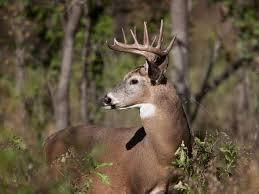

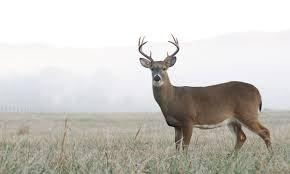

Deer are hoofed mammals known for their graceful bodies and long legs. Most male deer have antlers, which they shed and regrow annually. They are herbivores, generally feeding on a mix of grasses, plants, and leaves. Deer are found in various habitats across the world, including forests, grasslands, and wetlands.


In [31]:
#Execute a similarity search
results = mm_search([query_vector])

In [32]:
#Try another query
query_vector = queryToEmbedding(["green and yellow insect that cacoons"])

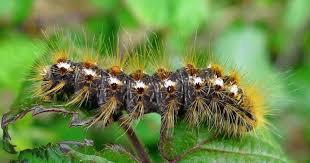

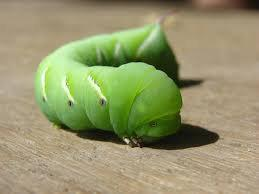

Caterpillars are the larval stage of butterflies and moths. They have a segmented body with a distinct head and typically several pairs of true legs, as well as additional false legs or prolegs. Caterpillars are primarily known for their voracious appetite, often eating leaves voraciously before pupating into their adult form.


In [33]:
#Execute a similarity search
results = mm_search([query_vector])

Now we have retrieved the most relevant text and images from KDB.AI vector database, the retrieval step of RAG is complete!

## 7. RAG Time!
We will use Google's Gemini Vision model to handle input text and images. We can now take our retrieved data and pass it to Gemini for the second phase of RAG: Generation

In [ ]:
# Pip install necessary packages (!!! Note: On Colab, some Google packages may already be installed: do NOT restart the runtime if prompted to)
!pip install google-generativeai langchain-google-genai streamlit pillow

In [35]:
# Setup Google API Key, get it here: https://makersuite.google.com/
import os
from getpass import getpass
os.environ["GOOGLE_API_KEY"] = (
    os.environ["GOOGLE_API_KEY"]
    if "GOOGLE_API_KEY" in os.environ
    else getpass("Google API Key: ")
)

Google API Key: ··········


In [36]:
import google.generativeai as genai
genai.configure(api_key = os.environ['GOOGLE_API_KEY'])

In [37]:
# Use Gemini Pro Vision model to handle multimodal inputs
vision_model = genai.GenerativeModel('gemini-1.5-flash')

In [38]:
# Helper function to get retrieved data ready to send to Gemini
def RAG_Setup(results, retrieved_data_for_RAG):
    for index, row in results[0].iterrows():
        if row.iloc[2] == 'image':
            image = Image.open(row.iloc[1])
            retrieved_data_for_RAG.append(image)
            display(image)  # Show the image
        elif row.iloc[2] == 'text':
            text = read_text_from_file(row.iloc[1])
            print(text) # Show the text
            retrieved_data_for_RAG.append(text)
    return retrieved_data_for_RAG


Construct the query to send to Gemini:

Retrieved Data: 


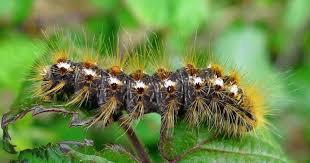

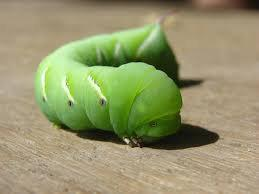

Caterpillars are the larval stage of butterflies and moths. They have a segmented body with a distinct head and typically several pairs of true legs, as well as additional false legs or prolegs. Caterpillars are primarily known for their voracious appetite, often eating leaves voraciously before pupating into their adult form.


In [39]:
prompt = "what can you tell me about caterpillars in the images? What species are they?"

#This will serve as the prompt being sent to Gemini:
query = "You will answer the given prompt using attached content: " + prompt

#Gemini accepts a list of inputs, which include texts and images retrieved from the vector database
#This input list will begin with the query defined above
RAG_list = [query]

#The input list and retrieved results are now passed into the RAG_Setup helper function
#retieved_data_for_RAG will now contain a list including the prompt and retrieved text/image data
print("Retrieved Data: ")
retrieved_data_for_RAG = RAG_Setup(results, RAG_list)

Execute generation step of RAG:

In [40]:
#Gemini generates a response based on the retrieved_data_for_RAG input list, completing the RAG iteration
response = vision_model.generate_content(retrieved_data_for_RAG)
print(response.text)

Based on the provided images and description:

The first image shows a hairy caterpillar with dark segments marked by white spots and long, yellowish hairs.  While I cannot definitively identify the species from the image alone, its appearance suggests it is likely a type of **tussock moth caterpillar**. Many tussock moth caterpillars have similar hairy bodies with contrasting colors.  More specific identification would require additional information such as location and host plant.


The second image shows a smooth, green caterpillar with diagonal stripes.  This is consistent with the appearance of various **sphinx moth (hawk moth) caterpillars**. Again, without further information (location, host plant, etc.), precise species identification isn't possible.  Many sphinx moth caterpillars share this general body shape and color.



## 8. Delete the KDB.AI Table
Once finished with the table, it is best practice to drop it.

In [41]:
table.drop()

#### Take Our Survey
We hope you found this sample helpful! Your feedback is important to us, and we would appreciate it if you could take a moment to fill out our brief survey. Your input helps us improve our content.

Take the [Survey](https://delighted.com/t/dfAHRG9R)